# MAE 598 Project 1

## Rocket Soft Landing

### Introduction

Consider a simple formulation of rocket landing where the rocket state $x(t)$ is represented by its distance to the ground $d(t)$ and its velocity $v(t)$, i.e., $x(t) = [d(t), v(t)]^T$, where $t$ specifies time. The control input of the rocket is its acceleration $a(t)$. The discrete-time dynamics follows:

Consider a simpliefied 2D formulation of a rocket landing problem. The rocket state $ x(t) $ is represented by the distances and velocities in X and Y directions respectively, orientation and the angular velocity, where $ t $ specifies time. The control inputs $ a(t) $ to the rocket are accelerations in  X and Y directions respectively.


State

$$ x(t) = [x, y, \dot{x}, \dot{y}, \theta, \dot{\theta}] $$

where,

$ x $ - Horizontal distence of the rocket CG from the origin

$ y $ - Vertical distence of the rocket CG from the origin

$ \dot{x} $ - Velocity of the rocket in *X* direction

$ \dot{y} $ - Velocity of the rocket in *Y* direction

$ \theta $ - Angle made by the longitudinal axis of the rocket with *Y*-axis

$ \dot{\theta} $ - Angular acceleration of the rocket about *Z*-axis



Action

$$ a(t) = [V, H] $$

where,

$ V $ - Thrust acceleartion at the base, along the longitudinal axis of the rocket

$ H $ - Thrust acceleartion at the base, perpendicular the longitudinal axis of the rocket


The rocket dynamics are described below:

$$
\begin{aligned}
\quad & \ddot{x} = V \sin\theta + H \cos\theta \\
\quad & \ddot{y} = V \cos\theta - H \sin\theta - D - g \\
\quad & \ddot{\theta} = (0.5 * L * H) \ / \  J
\end{aligned}
$$

The rocket mass $ M $ is assumed to be **one** to simplify the model.

Taking $ J = M L^2 \ / \ 12 $, $ \ \ddot{\theta} $ becomes
$$
\begin{aligned}
\ddot{\theta} = (6 * H) \ / \  L
\end{aligned}
$$

where,

$ \ddot{x} $ - Acceleration of the rocket in *X* direction

$ \ddot{y} $ - Acceleration of the rocket in *Y* direction

$ D $ - Acceleration due to the drag force experienced by the rocket

$ g $ - Acceleration due to gravity

$ J $ - Polar moment of inertia of the rocket about *Z*-axis

$ L $ - Length of the rocket

$ d $ - Diameter of the rocket



From the dynamics the new state can be written in discrete time form as below:


$$
\begin{aligned}
\quad & x(t+1) = x(t) + \dot{x}(t) \ \Delta t + \ddot{x}(t) \ \Delta t^2 \\
\quad & y(t+1) = y(t) + \dot{y}(t) \ \Delta t + \ddot{y}(t) \ \Delta t^2 \\
\quad & \dot{x}(t+1) = \dot{x}(t) + \ddot{x}(t) \ \Delta t \\
\quad & \dot{y}(t+1) = \dot{y}(t) + \ddot{y}(t) \ \Delta t \\
\quad & \theta(t+1) = \theta(t) + \dot{\theta}(t) \ \Delta t + \ddot{\theta}(t) \ \Delta t^2 \\
\quad & \dot{\theta}(t+1) = \dot{\theta}(t) + \ddot{\theta}(t)
\end{aligned}
$$


where $ \Delta t $ is a time interval. 

Further let the closed-loop controller be

$$
a(t) = f_{\theta}(x(t))
$$

where $ f_{\theta}(\cdot) $ is a neural network with parameters $ \theta $ which are to be determined through optimization.

For each time step we assign a loss as a function of the control input and the state: $ l(x(t), a(t)) $. In this example we will simply set $ l(x(t), a(t)) = 0 $ for all $ t=1...T-1 $ where $ T $ is the final time step. 

$$ 
\begin{aligned}
\quad l(x(T), a(T)) = \mathbb{E} \displaystyle \sum_{t=0}^{T-1} \|x(T) - x^*\|^2 = \mathbb{E} \displaystyle \sum_{t=0}^{T-1} w_1 \ (x(T) - 0)^2 + w_2 \ (y(T) - 0.5 L)^2 + w_3 \ (\dot{x}(T) - 0)^2 + w_4 \ (\dot{y}(T) - 0)^2 + w_5 \ (\theta(T) - 0)^2 + w_6 \ (\dot\theta(T) - 0)^2
\end{aligned}
$$

where,

$ x* $ - Target state at time $ T $

$ w $ - Weights applied to the state variable

This loss function encourages the rocket to reach zero state values for a stable landing condition.

The optimization problem is now formulated as:

$$
\begin{aligned}
\quad & \min_{\theta} \mathbb{E} \displaystyle \sum_{t=0}^{T-1} \|x(T) - x^*\|^2\\
\quad & s.t. \\
\quad & x(t+1) = x(t) + \dot{x}(t) \ \Delta t + \ddot{x}(t) \ \Delta t^2 \\
\quad & y(t+1) = y(t) + \dot{y}(t) \ \Delta t + \ddot{y}(t) \ \Delta t^2 \\
\quad & \dot{x}(t+1) = \dot{x}(t) + \ddot{x}(t) \ \Delta t \\
\quad & \dot{y}(t+1) = \dot{y}(t) + \ddot{y}(t) \ \Delta t \\
\quad & \theta(t+1) = \theta(t) + \dot{\theta}(t) \ \Delta t + \ddot{\theta}(t) \ \Delta t^2 \\
\quad & \dot{\theta}(t+1) = \dot{\theta}(t) + \ddot{\theta}(t) \\
\quad & a(t) = f_{\theta}(x(t)) ~\forall t=1...T-1
\end{aligned}
$$

While this problem is constrained it is easy to see that the objective function can be expressed as a function of $ x(T-1) $ and $ a(T-1) $ where $ x(T-1) $ as a function of $ x(T-2) $ and $ a(T-2) $ and so on. Thus it is essentially an unconstrained problem with respect to $ \theta $.

In the following we code this problem up with **PyTorch** which allows us to only build the forward pass of the loss (i.e. how we move from $x(1)$ to $x(2)$ and all the way to $x(T)$) and automatically get the gradient $ \nabla_{\theta} l(x(T), a(T)) $.
 


### Code

In [2]:
# Import libraries
import random
import numpy as np
import time
import matplotlib.pyplot as plt

import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import logging

logger = logging.getLogger(__name__)


np.random.seed(44)
t.manual_seed(44)

In [3]:
# Environment parameters
dt = 0.5 # Time step (seconds)
g = 9.81e-3 # gravity constant (km / s^2)

# Specifications (The data is chosen based on SpaceX Starship)
d = 0.009 # Diameter of the vehicle (km)
L = 0.05 # Length of the vehicle (km)
l = 0.5 * L # Assumed position of CG along the length (km)
# l1 = l2 = L / 2

Md = 100. # Dry mass of the vehicle (Metric tonnes)
Mf = 0.5 * 1200. # Mass of the fuel (Metric tonnes). Total mass capacity is 1200, fuel level is taken as some fraction of that during re-entry
M = Md + Mf # Initial weight of the vehicle (Metric tonnes)

T = 15. # Total thrust of the main booster (Metric-tonnes-km / s^2) - Converted from 15 MN
H = 0.5 # Net thrust of the side booster booster (Metric-tonnes-km / s^2) - Converted from 0.5 MN
phi = 0.35 # Thrust vectoring limit (rads) (20 deg in each direction Left-Right)

D = 0.204 # Drag force constant, multiply by velocity to compute the force (Metric-tonnes / km)

ve = 6 * 3.28 # Exhaust velocity of the engines (km / s)
# Number of engines = 6 (3 vacuum + 3 sea level)

# Compute acceleration terms from the forces
Ta = T / M
Ha = H / M
Dc = D / M

### Mulitple starts

In [4]:
# System Dynamics

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """       
        Units: km, metric tonnes, sec, rad
        
        state:
        state[0] = x (km)
        state[1] = y (km)
        state[2] = vx (km / s)
        state[3] = vy ((km / s)
        state[4] = theta (rad)
        state[5] = theta_dot (angular momentum) (rad / s)

        action:
        action[0]: thrust acceleration (Longitudinal)
        action[1]: thrust acceleration (Lateral)
        """

        for i in range(state.shape[0]):
            
            T_inst = Ta * action[i, 0]
            H_inst = Ha * (action[i, 1] - 0.5) * 2. 

            # # Without drag
            # dvxdt = (T_inst * t.sin(state[i, 4])) + (H_inst * t.cos(state[i, 4]))
            # dvydt = (T_inst * t.cos(state[i, 4])) - (H_inst * t.sin(state[i, 4])) - g

            # With drag
            dvxdt = (T_inst * t.sin(state[i, 4])) + (H_inst * t.cos(state[i, 4]))
            dvydt = (T_inst * t.cos(state[i, 4])) - (H_inst * t.sin(state[i, 4])) - (Dc * (state[i, 4] ** 2)) - g
            dwdt = (6 * H_inst) / L

            # dMdt = T_inst / ve # Max fuel mass rate (Metric tonnes / s)
            
            # Construct step vectors
            dvxdt_step = t.tensor([[(dt**2), 0., dt, 0., 0., 0.]]) * dvxdt
            dvydt_step = t.tensor([[0., (dt**2), 0., dt, 0., 0.]]) * dvydt
            dwdt_step = t.tensor([[0., 0., 0., 0., (dt**2), dt]]) * dwdt
            
            delta = dvxdt_step + dvydt_step + dwdt_step

            if i == 0:
                delta_batched = delta
                # print(delta_batched, i)
                
            else:
                delta_batched = t.cat((delta_batched, delta), dim=0)
                # print(delta_batched, i)
  
        # print(delta_batched)
        
        state = state + delta_batched

        # Update state
        step_mat = t.tensor([[1., 0., 0., 0., 0., 0.],
                             [0., 1., 0., 0., 0., 0.],
                             [dt, 0., 1., 0., 0., 0.],
                             [0., dt, 0., 1., 0., 0.],
                             [0., 0., 0., 0., 1., 0.],
                             [0., 0., 0., 0., dt, 1.]])
        
        state = t.matmul(state, step_mat)
        
        
#         noise = np.random.normal(0, 1, (state.shape[0], state.shape[1]))
#         state = state + 0.2 * noise
        
        # print(state.shape)

        return state
    
t.autograd.set_detect_anomaly(True)

In [5]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            # nn.Linear(dim_hidden, 2 * dim_hidden),
            # nn.Tanh(),
            # nn.Linear( 2 * dim_hidden, dim_hidden),
            # nn.Tanh(),
            # nn.Linear(dim_hidden, dim_hidden),
            # nn.Tanh(),
            # nn.ReLU(),
            nn.Linear(dim_hidden, dim_output),
            # nn.Tanh()
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        # print("Action: ", action)
        # print("Action dim: ", action.shape)
        return action

In [6]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        batch_sz = 20
        bounds = np.array([[-1.5, 1.5], 
                           [5, 6], 
                           [0, 0], 
                           [-0.1, 0.1], 
                           [1.4, 1.57],
                           [0, 0]]) # angle in rads
       
        state = t.tensor(np.random.uniform(bounds[:,0], bounds[:, 1], (batch_sz, bounds.shape[0])), requires_grad=False).float()
        print('Dim. state: ', state.shape)
        print('Initial state: ', state)
        return state
    
    
    def error(self, state):
        error = (1 * state[:, 0]**2 + 1 * (state[:, 1] - l)**2 + 1 * state[:, 2]**2 + 1 * state[:, 3]**2 + 1 * state[:, 4]**2 + 1 * state[:, 5]**2).mean()
        # error = t.nn.functional.normalize(state**2, dim=0).mean().sum()
        return error

In [7]:
# set up the optimizer

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.1)
        # self.optimizer = optim.Adam(self.parameters, lr=0.1)
        # self.optimizer = optim.SGD(self.parameters, lr=0.01)
        # self.optimizer = optim.SGD(self.parameters, lr=0.01, momentum=0.9)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.6f' % (epoch + 1, loss))
            
            # self.visualize()
            if epoch % 3 == 2:
                self.visualize()
            
            return loss.detach().numpy()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        
        print(data.shape)
        fig = plt.figure(figsize=(40, 8))       
        # fig1 = plt.figure(figsize=(5, 5)) 
        ax1 = fig.add_subplot(161)
        ax2 = fig.add_subplot(162)
        ax3 = fig.add_subplot(163)
        ax4 = fig.add_subplot(164)
        ax5 = fig.add_subplot(165)

        # ax7 = fig1.add_subplot(111)

        for i in range(data.shape[1]):
            x = data[:, i, 0]
            y = data[:, i, 1]

            vx = data[:, i, 2]
            vy = data[:, i, 3]
            
            theta = data[:, i, 4]
            omega = data[:, i, 5]
            
            ax1.plot(x, y)
            ax1.set_xlabel('[X]')
            ax1.set_ylabel('[Y]')
            
            # ax7.plot(y)
            # ax7.set_xlabel('[Time]')
            # ax7.set_ylabel('[X]')
            # # ax1.set_xlim(-0.5, 0.5)
            # # ax1.set_ylim(0, 10)
            
            ax2.plot(vx)
            ax2.set_xlabel('[Time]')
            ax2.set_ylabel('[Vx]')
            # ax2.set_xlim(0, data.shape[0])
            # ax2.set_ylim(0, 100)
            
            ax3.plot(vy)
            ax3.set_xlabel('[Time]')
            ax3.set_ylabel('[Vy]')
            # ax3.set_xlim(0, data.shape[0])
            # ax3.set_ylim(0, 100)
            
            ax4.plot(theta)
            ax4.set_xlabel('[Time]')
            ax4.set_ylabel('[Theta]')
            # ax4.set_xlim(0, data.shape[0])
            # ax4.set_ylim(0, 100)
            
            ax5.plot(omega)
            ax5.set_xlabel('[Time]')
            ax5.set_ylabel('[Omega]')
            
        plt.show()

Dim. state:  torch.Size([20, 6])
Initial state:  tensor([[ 1.0045e+00,  5.1048e+00,  0.0000e+00, -2.7900e-02,  1.4611e+00,
          0.0000e+00],
        [-3.1866e-01,  5.4091e+00,  0.0000e+00,  4.2030e-02,  1.5633e+00,
          0.0000e+00],
        [-2.1705e-01,  5.1135e+00,  0.0000e+00,  9.1494e-02,  1.5604e+00,
          0.0000e+00],
        [ 4.3923e-01,  5.2138e+00,  0.0000e+00, -7.2171e-02,  1.4780e+00,
          0.0000e+00],
        [-7.2465e-01,  5.6649e+00,  0.0000e+00, -7.0230e-02,  1.4957e+00,
          0.0000e+00],
        [-9.8132e-01,  5.1040e+00,  0.0000e+00, -8.9621e-03,  1.5351e+00,
          0.0000e+00],
        [ 9.1505e-01,  5.3774e+00,  0.0000e+00, -8.8220e-02,  1.5209e+00,
          0.0000e+00],
        [ 1.1478e+00,  5.7261e+00,  0.0000e+00,  4.2046e-02,  1.5186e+00,
          0.0000e+00],
        [ 1.1450e+00,  5.0950e+00,  0.0000e+00, -1.4553e-03,  1.4185e+00,
          0.0000e+00],
        [ 1.4529e+00,  5.2716e+00,  0.0000e+00, -6.7153e-02,  1.4225e+00,
    

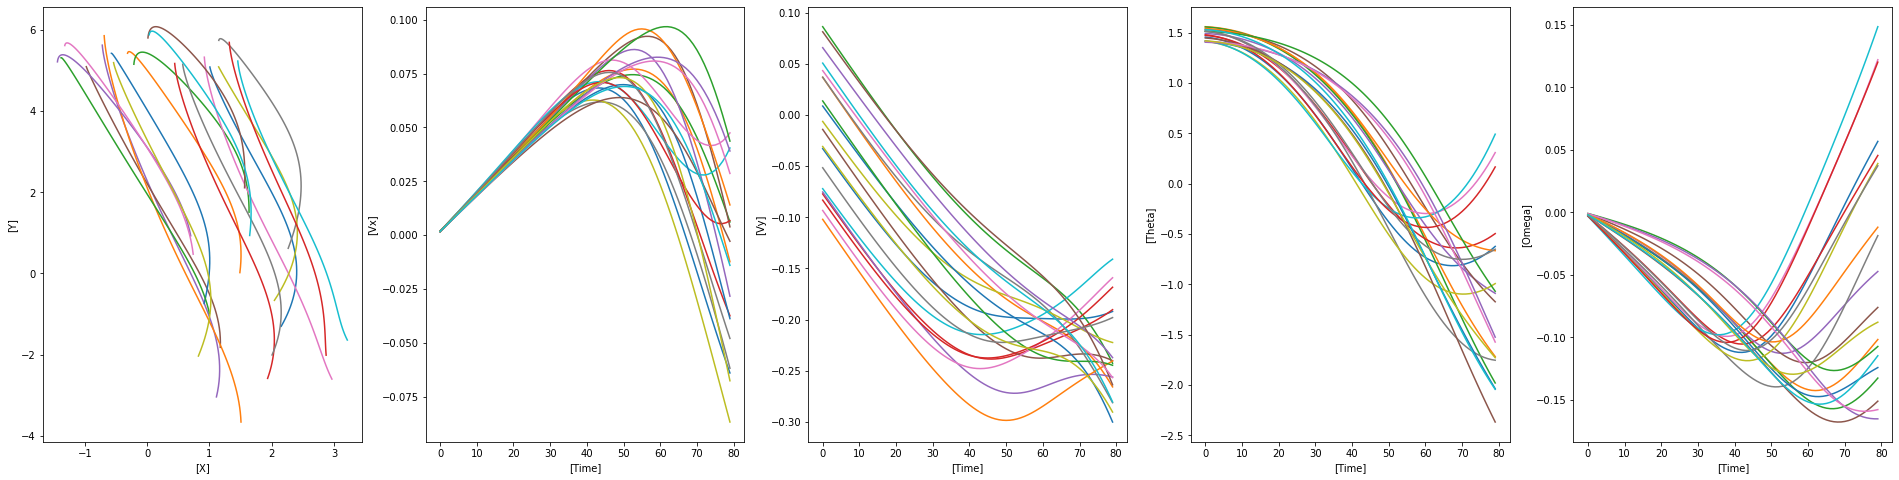

[4] loss: 3.884941
[5] loss: 1.551491
[6] loss: 1.070381
(80, 20, 6)


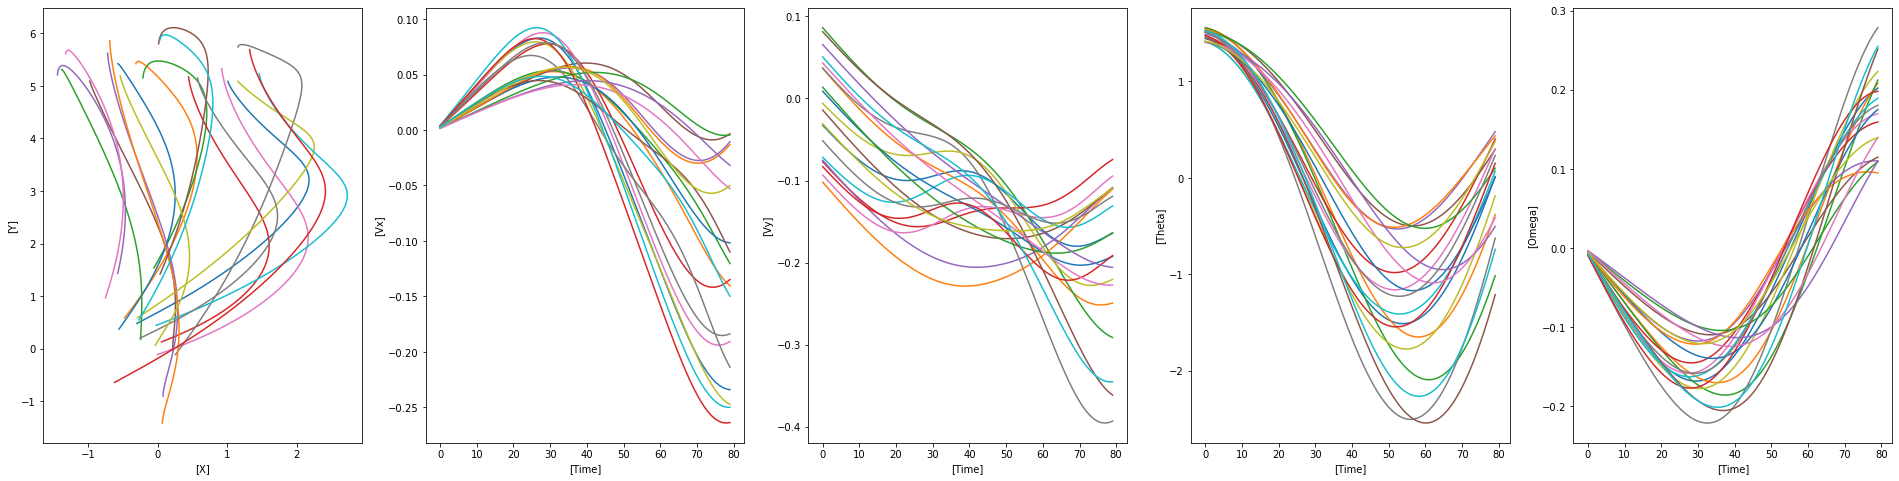

[7] loss: 0.627098
[8] loss: 0.540758
[9] loss: 0.472000
(80, 20, 6)


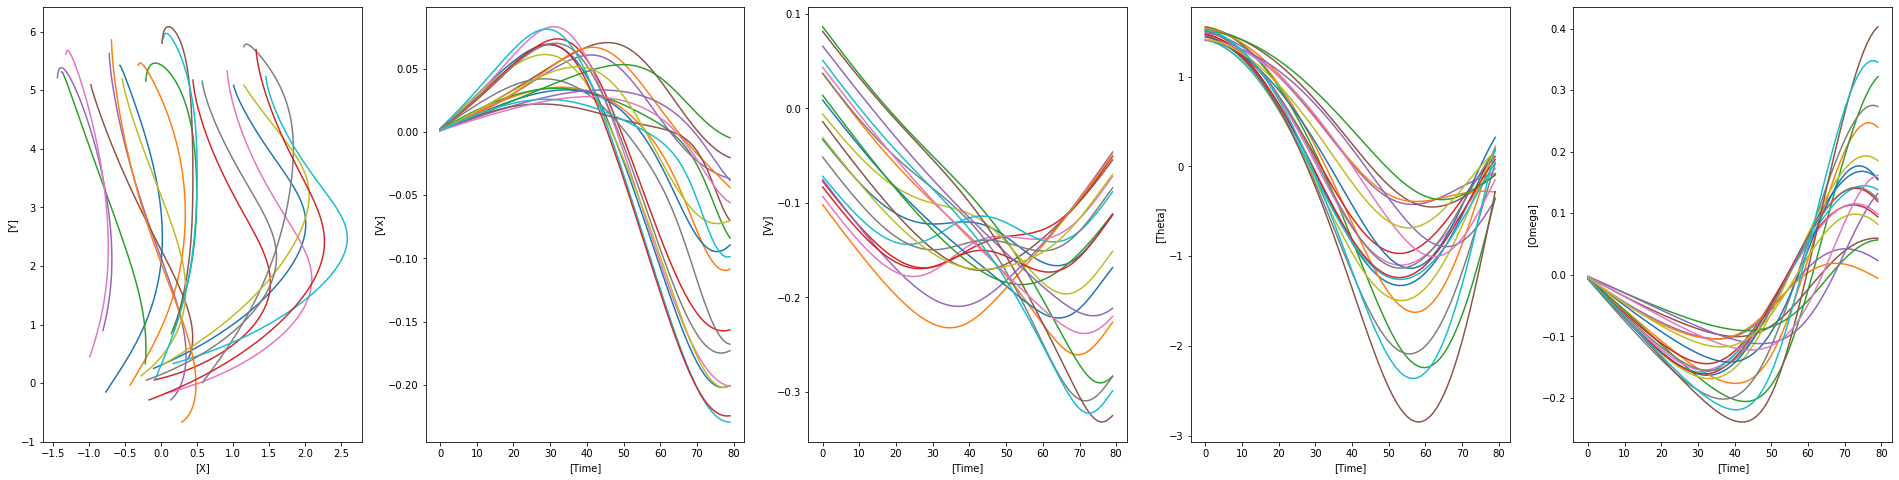

[10] loss: 0.396498
[11] loss: 0.310687
[12] loss: 0.274949
(80, 20, 6)


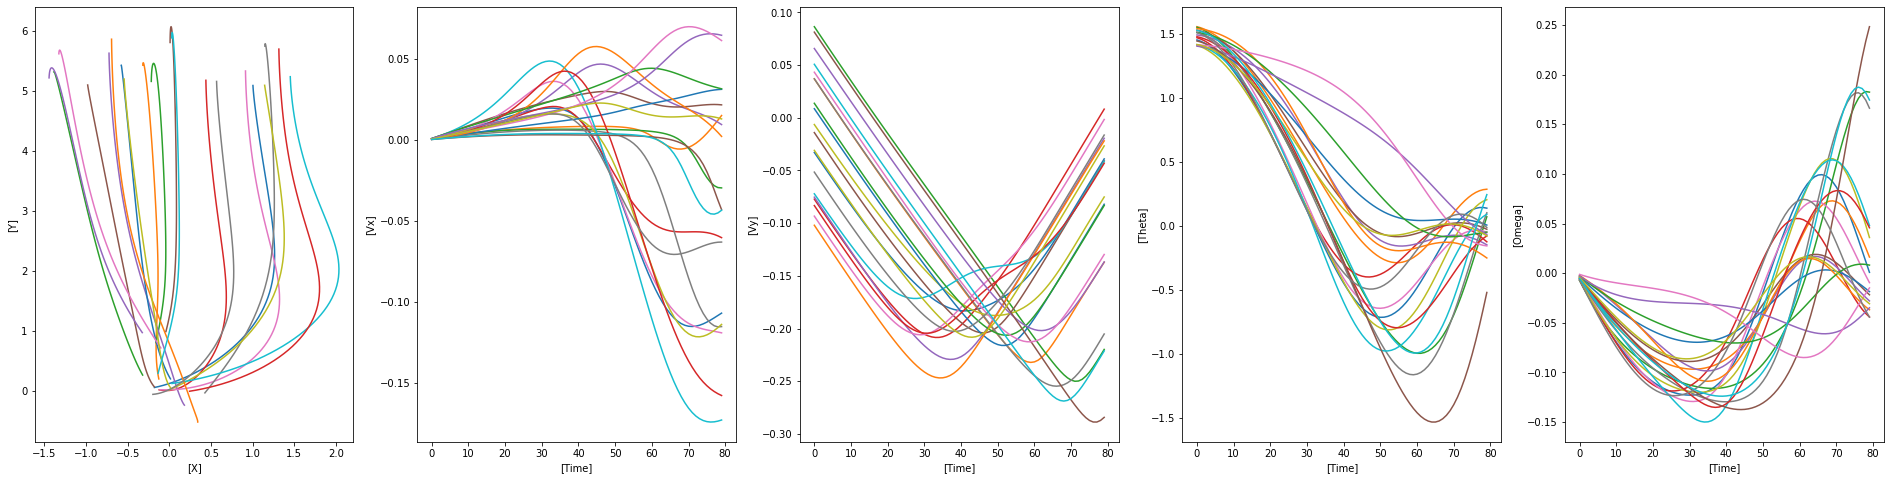

[13] loss: 0.236213
[14] loss: 0.218808
[15] loss: 0.188886
(80, 20, 6)


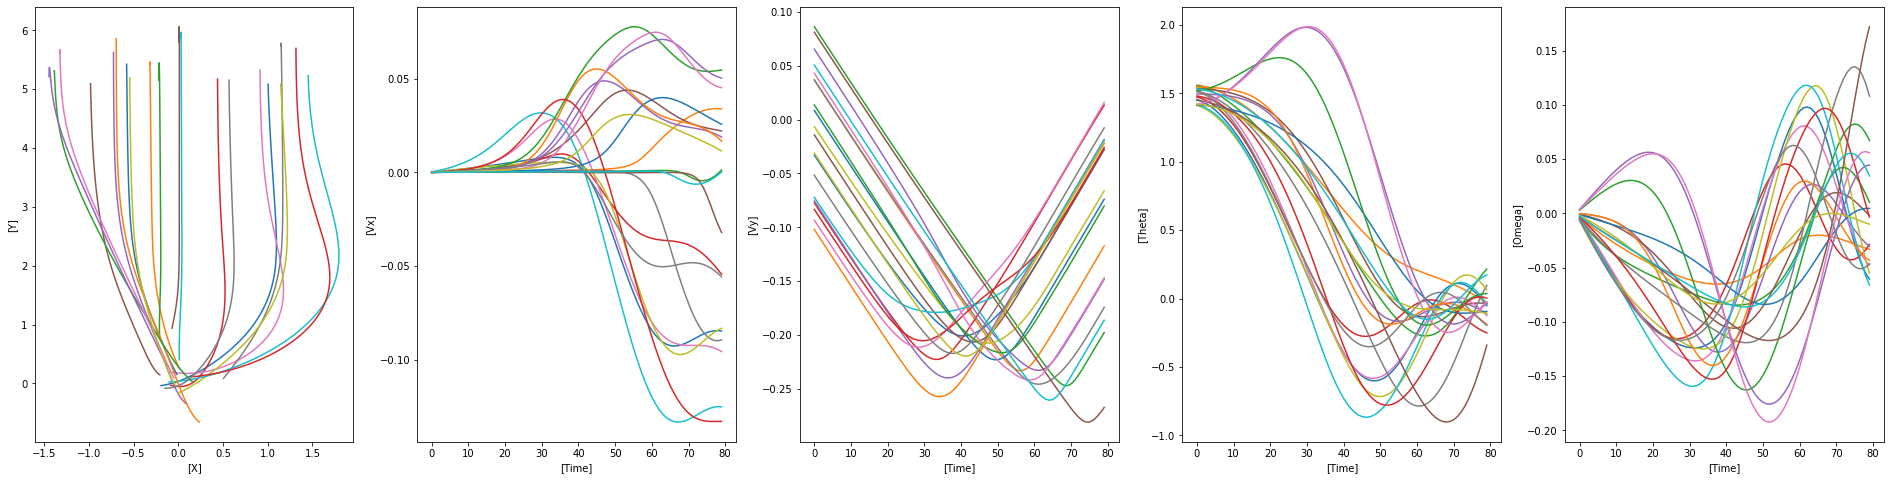

[16] loss: 0.174160
[17] loss: 0.164722
[18] loss: 0.158168
(80, 20, 6)


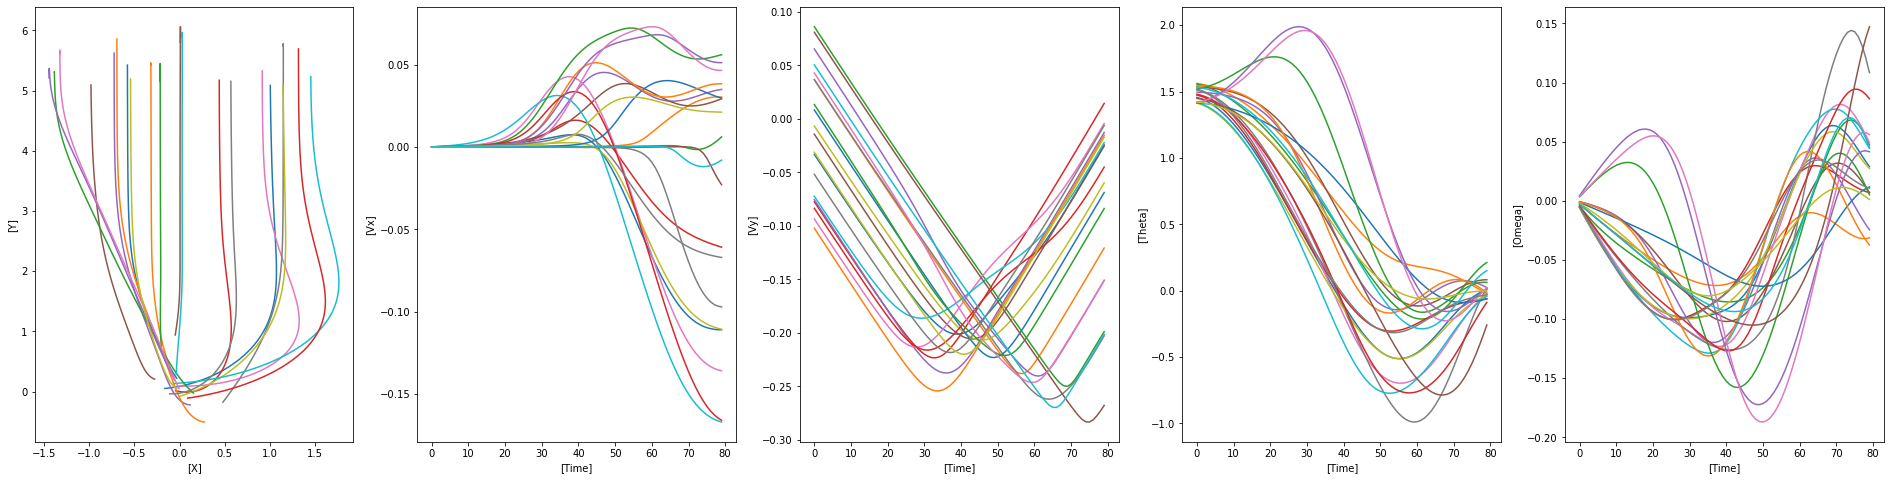

[19] loss: 0.149628
[20] loss: 0.142785
[21] loss: 0.135430
(80, 20, 6)


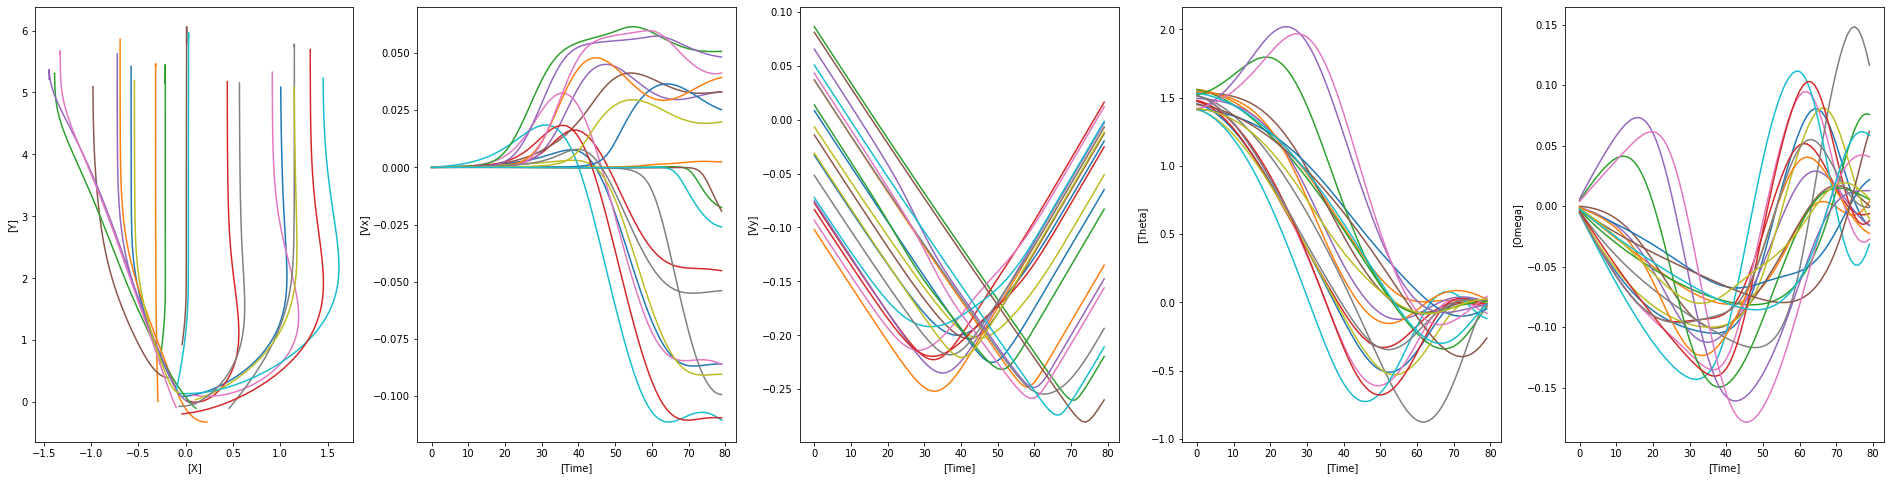

[22] loss: 0.131874
[23] loss: 0.126926
[24] loss: 0.123477
(80, 20, 6)


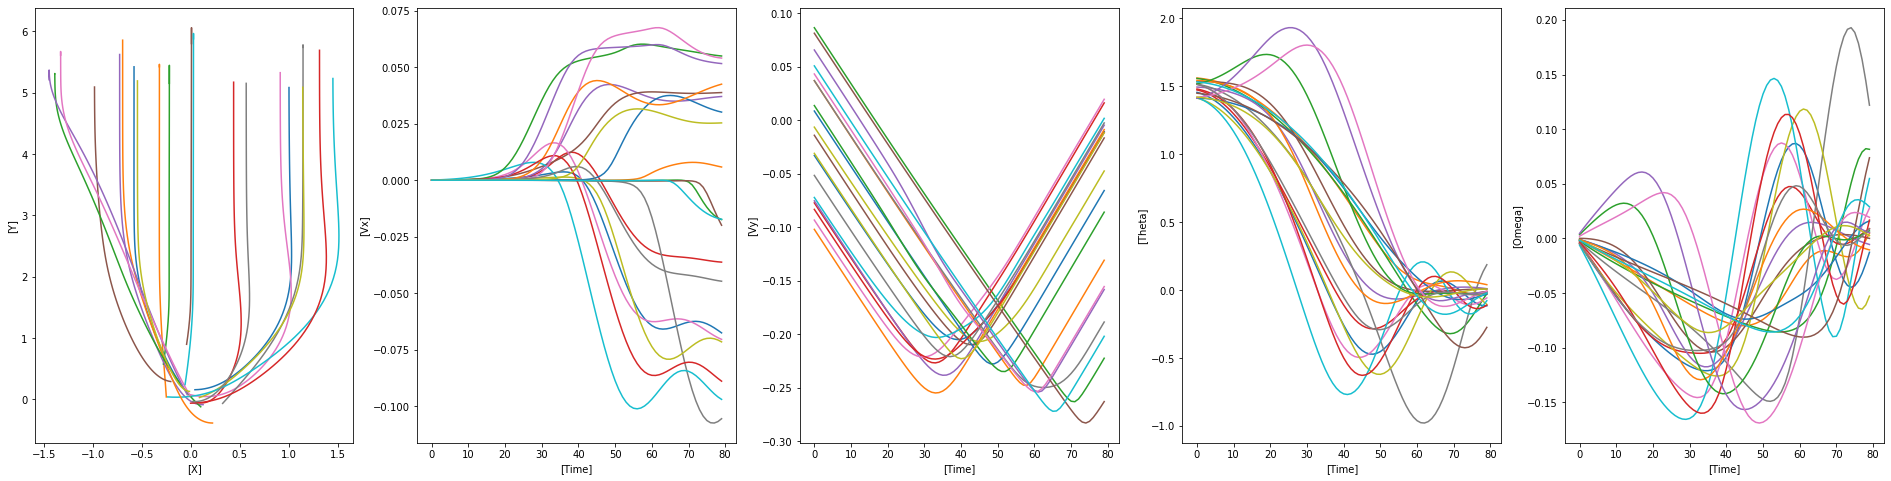

[25] loss: 0.121885
[26] loss: 0.120371
[27] loss: 0.118002
(80, 20, 6)


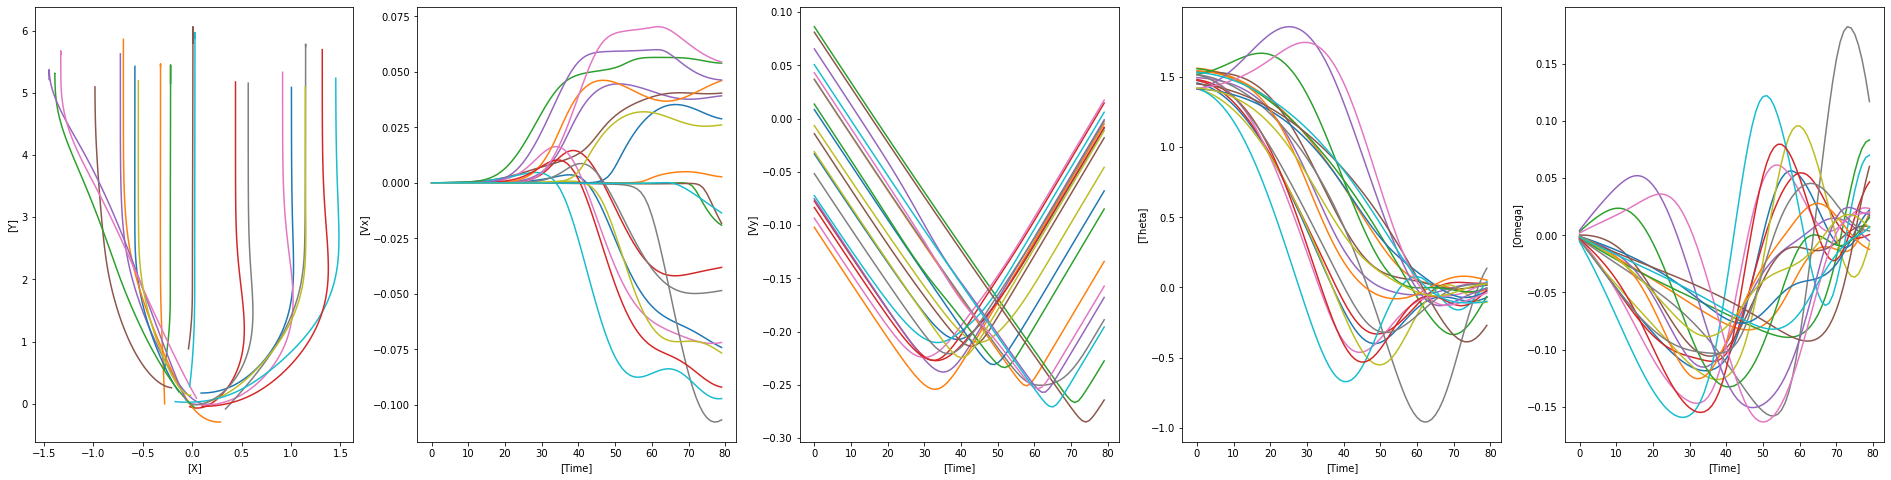

[28] loss: 0.115851
[29] loss: 0.115256
[30] loss: 0.114451
(80, 20, 6)


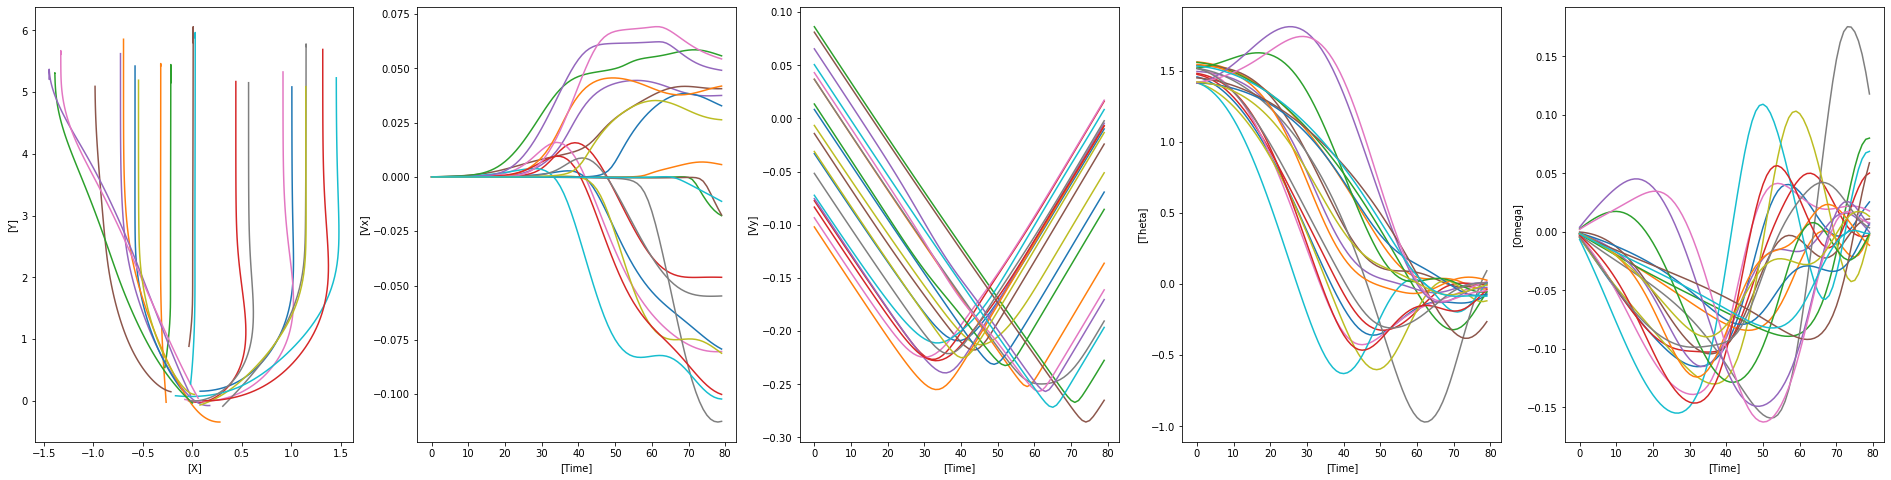

In [8]:
# Now it's time to run the code!

T = 80  # number of time steps
dim_input = 6  # state space dimensions
dim_hidden = 12  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer

loss = []
loss.append(o.train(30))  # solve the optimization problem

plt.plot(loss)
plt.show()
return